In [9]:
from datetime import datetime, timedelta
from utils import get_prices
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


EPSILON = 1e-10

# if __name__ == "__main__":

start_time = '1514764800'
end_time = '1523404800'

df_ = get_prices(
    'btc', 'usdt',
    datetime(2020, 1, 1),
    duration=timedelta(days=7),
    proxy_port='13070',
    verbose=2)

# df_ = pd.read_csv('data/BTCUSDT[' + start_time + '000_' + end_time + '000].csv')
# df_.drop(['Unnamed: 0'], inplace=True, axis=1)
df_['Time'] = pd.to_datetime(df_['Time'])
df_.set_index('Time', inplace=True, drop=True)

times_index = pd.date_range(start=pd.to_datetime(start_time, unit='s'),
                            end=pd.to_datetime(end_time, unit='s'),
                            periods=(int(end_time) - int(start_time) + 1) / 60 + 1)

df = pd.DataFrame(None, columns=df_.columns, index=times_index[:-1])

selected_indices = list(set(df_.index).intersection(set(times_index)))
df.loc[selected_indices, df_.columns] = df_.loc[selected_indices].copy()

 Request 1 took 2.072 seconds...
 Request 2 took 2.265 seconds...
 Request 3 took 2.388 seconds...
 Request 4 took 2.257 seconds...
 Request 5 took 2.373 seconds...
 Request 6 took 2.188 seconds...
 Request 7 took 2.120 seconds...
 Request 8 took 2.341 seconds...
 Request 9 took 2.184 seconds...
 Request 10 took 2.371 seconds...
 Request 11 took 1.777 seconds...


In [10]:
window = int(timedelta(hours=1) / timedelta(minutes=1))
period = 10

df['Feature 1'] = df['Taker Buy Volume'] / (df['Volume'] + EPSILON) * 100
df['Feature 2'] = (df['Volume'] + EPSILON).pct_change()
df['Feature 3'] = df['Close'].pct_change() * 1000
tmp = df['High'].rolling(window).max()
df['Feature 4'] = (tmp-df['Open']) / (tmp-df['Low'].rolling(window).min()) * 100

# for i in range(period):
#     df[f'Return {i+1} min'] = (df['Close'].shift(-i-1) / df['Close'] - 1) * 100
df

,Market,Open,High,Low,Close,Volume,Value,No. Trades,Taker Buy Volume,Taker Buy Value,Feature 1,Feature 2,Feature 3,Feature 4
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-10 23:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-10 23:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-10 23:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-10 23:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df[df['Feature 2'] > 3, ['Feature 1', 'Feature 3', 'Feature 4', 'Volume', 'Taker Buy Volume']].to_csv('data/data.csv')

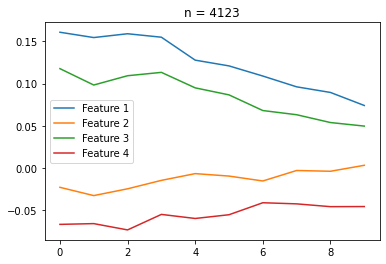

In [4]:
from scipy.stats import pearsonr
result = []
data = df.dropna().copy()
data = data[(data['Feature 2'] >= 3) & (data['No. Trades'] > 100)]
for i in range(period):
    for j in range(4):
        result.append(pearsonr(data[f'Return {i+1} min'], data[f'Feature {j+1}']))
result = np.array(result)
result = result.reshape(-1, 8)
for j in range(4):
    plt.plot(result[:, 2*j], label=f'Feature {j+1}')
plt.legend()
plt.title(f'n = {len(data)}')
plt.show()

In [6]:
# t_train_start = datetime(2018, 1, 1, 1)
# t_train_duration = timedelta(hours=6)
# x_train = x.loc[t_train_start:t_train_start+t_train_duration-timedelta(minutes=1)]
# A =